In [ ]:
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)

from zipfile import ZipFile
! cp '/content/drive/MyDrive/ML_Capstone/drive-download.zip' '/content'
from zipfile import ZipFile
zip = ZipFile('/content/drive-download.zip')
zip.extractall()

Mounted at /content/drive/


In [ ]:
# importing required packages
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import pickle as pkl
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
import pandas as pd

# Dataset and Dataloaders

In [ ]:
# Set device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Lazy Loading

data
-train
  - X
    - 1
      - rgb
        - 0.png
        - 1.png
        - 2.png
      - depth.npy
      - field_id.pkl
    
    - 2

    - ...
  - Y
    - 1.npy
    - 2.npy

-test

In [ ]:
class LazyLoadDataset(Dataset):
  def __init__(self,path,train=True,transform=None):
    self.train = train
    self.transform = transform
    path = path + ("train/" if self.train else "test/")

    self.pathX = path + "X/"
    self.pathY = path + "Y/"

    self.data = os.listdir(self.pathX)

  def __getitem__(self,idx):
    f = self.data[idx]

    # X
    # read rgb images
    img0 = Image.open(self.pathX + f + "/rgb/0.png")/255
    
    if self.transform is not None:
      img0 = self.transform(img0)

    # read field ID
    field_id = pkl.load(open(self.pathX + f + "/field_id.pkl","rb"))

    if self.train==True:
      # Y 
      Y = np.load(self.pathY + f + ".npy")*1000
      return (img0.float().type(torch.float32),field_id),torch.from_numpy(Y).float().type(torch.float32)

    else: # if test, there is no Y
      return img0.float().type(torch.float32),field_id

  def __len__(self):
    return len(self.data)


# Normalization: Compute Mean and Std

In [ ]:
train_dataset_raw = LazyLoadDataset("/content/",train=True,transform=ToTensor()) 
means=[]
stds=[]
for i in range(3396):
  (img_i, id_i),Y_i=train_dataset_raw[i]
  means.append([torch.mean(img_i[0]).item(),torch.mean(img_i[1]).item(),torch.mean(img_i[2]).item()])
  stds.append([torch.std(img_i[0]).item(),torch.std(img_i[1]).item(),torch.std(img_i[2]).item()])

In [ ]:
img_i

tensor([[[0.5882, 0.5882, 0.5882,  ..., 0.4549, 0.4510, 0.4431],
         [0.5843, 0.5843, 0.5804,  ..., 0.4549, 0.4549, 0.4588],
         [0.5961, 0.5882, 0.5882,  ..., 0.4549, 0.4549, 0.4549],
         ...,
         [0.0745, 0.0706, 0.0510,  ..., 0.4902, 0.4902, 0.4902],
         [0.0784, 0.0706, 0.0471,  ..., 0.4784, 0.4863, 0.4941],
         [0.0784, 0.0706, 0.0510,  ..., 0.4863, 0.4784, 0.4824]],

        [[0.6157, 0.6157, 0.6157,  ..., 0.4549, 0.4510, 0.4431],
         [0.6118, 0.6118, 0.6078,  ..., 0.4510, 0.4510, 0.4549],
         [0.6235, 0.6157, 0.6157,  ..., 0.4510, 0.4510, 0.4510],
         ...,
         [0.1059, 0.1020, 0.0824,  ..., 0.4941, 0.4941, 0.4941],
         [0.1098, 0.1020, 0.0784,  ..., 0.4902, 0.4980, 0.5059],
         [0.1098, 0.1020, 0.0824,  ..., 0.4980, 0.4902, 0.4941]],

        [[0.6392, 0.6392, 0.6392,  ..., 0.4392, 0.4353, 0.4275],
         [0.6431, 0.6431, 0.6392,  ..., 0.4510, 0.4510, 0.4549],
         [0.6471, 0.6392, 0.6392,  ..., 0.4588, 0.4510, 0.

In [ ]:
means

[[0.4072049558162689, 0.4196295738220215, 0.42293933033943176],
 [0.39515116810798645, 0.4204903841018677, 0.4474625587463379],
 [0.411945641040802, 0.42667049169540405, 0.4311847984790802],
 [0.42221638560295105, 0.43482255935668945, 0.43747496604919434],
 [0.40006017684936523, 0.4115472137928009, 0.4123711585998535],
 [0.3899073600769043, 0.42528894543647766, 0.45655059814453125],
 [0.4061024785041809, 0.40459659695625305, 0.4170721769332886],
 [0.39185068011283875, 0.4292588531970978, 0.46270549297332764],
 [0.4204326868057251, 0.41646164655685425, 0.4299409091472626],
 [0.36217716336250305, 0.38875246047973633, 0.418456494808197],
 [0.39119774103164673, 0.43640774488449097, 0.4447545111179352],
 [0.43049103021621704, 0.44528594613075256, 0.4521219730377197],
 [0.36412352323532104, 0.3993360102176666, 0.4300159215927124],
 [0.3888515532016754, 0.4297860860824585, 0.45985350012779236],
 [0.3870358467102051, 0.41358354687690735, 0.44159507751464844],
 [0.35703301429748535, 0.382744848

In [ ]:
norm_mean=np.mean(means,axis =0)
norm_mean = list(norm_mean)
norm_mean

[0.3959879955305368, 0.41699021958139393, 0.43522507327886295]

In [ ]:
norm_std=np.mean(stds,axis=0)
norm_std = list(norm_std)
norm_std

[0.21113784175510963, 0.1986706505394656, 0.1991702498400801]

# Train Dataset & Train loader

In [ ]:
#transform=transforms.Compose([transforms.ToTensor()])
train_dataset = LazyLoadDataset("/content/",transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std)])) 

In [ ]:
(img0, field_id), Y = train_dataset[0]

In [ ]:
img0.shape

torch.Size([3, 224, 224])

In [ ]:
batch_size_train = 4
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)

torch.Size([4, 3, 224, 224])


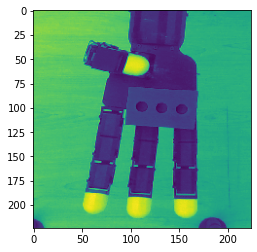

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
  #print(data) #plot the channel 3 of img0 in one batch
  print(data[0].shape)
  plt.imshow(data[0][0][1])
  #plt.show()
  #plt.imshow(data[0])
  break

# Test Dataset & Test loader

In [ ]:
test_dataset = LazyLoadDataset("/content/",train=False,transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std),
                   ])) 

batch_size_test = 2
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=True)

# Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
      
        # We use Sequential for simplicity
        self.stack = nn.Sequential(nn.Conv2d(input_channels, conv_feature,kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.Conv2d(conv_feature, conv_feature,kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   
                                   nn.Flatten(),
                                   nn.Linear(conv_feature*53*53, fc_feature),
                                   nn.ReLU(),
                                   nn.Linear(fc_feature, output_size)
        )
                               
    def forward(self, x):
        x = self.stack(x)
        return x

In [ ]:
# Model input/output settings
input_channels = 3
conv_feature = 6 
fc_feature = 50
output_size=12

In [ ]:
def train(epoch, model, optimizer,loader=train_loader):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    for batch_idx,((data, id),target) in enumerate(loader):
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.view(len(id),3,224, 224)

        # consider passing different data augmentation in training
        # data = F.invert()
        # data = F.adjust_sharpness(data,sharpness_factor = 0.5)
        # data = F.adjust_hue(data,hue_factor = 0.9)
        # data = F.adjust_saturation(data,saturation_factor = 0.5)

        # make sure we erase all the gradients before computing new ones
        optimizer.zero_grad() 
        
        # forward propagation
        output = model(data)
        #print(output.dtype)

        #RMSE loss
        loss = torch.sqrt(nn.functional.mse_loss(output,target))
        
        # backward propagation
        loss.backward()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss))
            

In [ ]:
def test(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    ids = []
    preds = []
    with torch.no_grad():
      for batch_idx,(data, id) in enumerate(test_loader):
        # send to device
        data = data.to(device)          
        pred = model(data)
        for i in range(len(id)):
          ids.append(id[i])
          preds.append(np.array(pred[i].cpu()/1000,dtype="float64"))

    return ids, preds  
    

In [ ]:
def get_n_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Cross-Validation & Grid-Search for determining hyperparameters

What should hyperparameters in the models be? We could perform grid-search on the whole train dataset and pick the best-performing hyerparameters. But to avoid over-fitting on the train dataset, we split the whole train dataset into 9:1.




*   cross_val_train_set (90% of train dataset)
*   cross_val_test_set (10% of train dataset)


We train our model on the cross_val_train_set and test our model on cross_val_test_set. We pick the best-performing hyperparameters on the cross_val_test_set.

After all these steps, we train our model using the picked hyperparameters on the whole train dataset.



In [ ]:
cross_val_train_set, cross_val_test_set = train_test_split(train_dataset, test_size=0.1)

In [ ]:
# Sanity Check
len(cross_val_train_set) == int(len(train_dataset)*0.9)
len(cross_val_train_set)

In [ ]:
batch_size_cross_val_train = 4
batch_size_cross_val_test = len(cross_val_test_set) # = 340
len(cross_val_test_set)

In [ ]:
cross_val_train_loader=DataLoader(cross_val_train_set,batch_size=batch_size_cross_val_train,shuffle=True)
cross_val_test_loader=DataLoader(cross_val_test_set,batch_size=batch_size_cross_val_test,shuffle=True)

In [ ]:
len(cross_val_test_loader)

In [ ]:
def cross_val(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    # We can just edit on the code for train(). We should delete the bakward propagation part and optimizer part.

    with torch.no_grad():
      for batch_idx,((data, id),target) in enumerate(cross_val_test_loader):
          # send to device
          if batch_idx==0:
            data, target = data.to(device), target.to(device)
            
            # forward propagation
            output = model(data)

            #RMSE loss
            loss = torch.sqrt(nn.functional.mse_loss(output,target)) 
            return loss.item()

In [ ]:
def SGD_hyper_tuning(lr_list,momentum_list):  
  for j in momentum_list:
    for i in lr_list:
      model_cnn = CNN(input_channels, conv_feature, fc_feature, output_size) # create CNN model
      model_cnn.to(device)
      print("lr=",i,"momentum=",j)
      train(epoch=0, model=model_cnn, optimizer=torch.optim.SGD(model_cnn.parameters(), lr=i,momentum=j),loader=cross_val_train_loader)
      print("Validation Performance:",cross_val(model_cnn))

In [ ]:
lr_list = [1e-5,1e-4,1e-3,1e-2,1e-1]
momentum_list = [0.99,0.97,0.95,0.93,0.91]
SGD_hyper_tuning(lr_list,momentum_list)

Top 3 Performance

1.  lr = 1e-3, momentum = 0.91
2.  lr = 1e-3, momentum = 0.95
3.  lr = 1e-4, momentum = 0.93

In [ ]:
lr_list = [8e-4,9e-4,1e-3,2e-3,3e-3]
momentum_list = [0.99,0.97,0.95,0.93,0.91]
SGD_hyper_tuning(lr_list,momentum_list)

Top 5 Performance
1.   lr = 1e-3, momentum = 0.91
2.   lr = 9e-4, momentum = 0.95
3.   lr = 8e-4, momentum = 0.93
4.   lr = 8e-4, momentum = 0.95
5.   lr = 9e-4, momentum = 0.93


#lr=1e-3, momentum=0.91, 20 epoch, train_batch_size = 4, no lr decay

In [ ]:
model_cnn = CNN(input_channels, conv_feature, fc_feature, output_size) # create Cnn model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-3,momentum=0.91) 

print("lr=",1e-3,"momentum=",0.91)
for epoch in range(20):
  train(epoch, model=model_cnn, optimizer=torch.optim.SGD(model_cnn.parameters(), lr=1e-3,momentum=0.91),loader=train_loader)


In [ ]:
torch.save(model_cnn,'/content/drive/MyDrive/ML_Capstone/project_v9_CNN_AUG3img0_0001091_nodecay_20ep.pt')
model_cnn = torch.load('/content/drive/MyDrive/ML_Capstone/project_v9_CNN_AUG3img0_0001091_nodecay_20ep.pt')
model_cnn.eval()
ids,preds = test(model_cnn)

outfile = '/content/drive/MyDrive/ML_Capstone/submission_v9_AUG3img0_0001091_nodecay_20ep.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']

df = pd.concat([pd.DataFrame(ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))